In [1]:

import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import plotly.express as px

10 people

17 chocolates

Each chocolate has some mean appeal and variance of appeal on a latent quality scale

Each person has an individual quality score for each choclate drawn from the appeal distributions for each chocolate

Each person's ranking of the chocolates provides information about whether the quality score for a chocolate is higher or lower than the quality score for another chocolate, but not the specific values on the latent scale

Some chocolates are liked by some people but disliked by others

Some chcocolates are generally agreed to be nicer than others

In [2]:
n_people = 10
n_chocs = 17

np.random.seed(123)

choc_mus_true = np.random.normal(0, 1, n_chocs)[np.newaxis,:]
choc_sigmas_true = np.random.gamma(5, 0.1, size=n_chocs)[np.newaxis,:]

choc_ratings_true = np.random.normal(choc_mus_true,
                                     choc_sigmas_true,
                                     size=(n_people,
                                     n_chocs))

choc_rankings_true = np.argsort(choc_ratings_true, axis=1)

In [3]:
with pm.Model() as model:

    choc_sigmas_fitted = pm.Gamma("choc_sigmas_fitted",
                                        alpha=5,
                                        beta=10,
                                        shape=(n_chocs))
    
    # overall distribution of mean preference values for chocolates
    choc_mus_fitted = pm.Normal("choc_mus_fitted",
                            0,
                            1,
                            shape=(n_chocs))

    # calculate standard deviation of fitted mu values to normalise scale of person ratings
    choc_mus_std = pm.Deterministic("choc_mus_std",
                                    pt.std(choc_mus_fitted))

    choc_mus_mean = pm.Deterministic("choc_mus_mean",
                                pt.mean(choc_mus_fitted))

    # map order of chocolate mus to individual ranks for use in ordered transform
    choc_mus_mapped = pm.Deterministic("choc_mus_mapped",
                                        (choc_mus_fitted[choc_rankings_true])/choc_mus_std)

    # map order of chocolate sigmas to individual ranks for use in ordered transform
    choc_sigmas_mapped = pm.Deterministic("choc_sigmas_mapped",
                                            choc_sigmas_fitted[choc_rankings_true])

    #individual distributions of preferences across chocolates, hierarchically related to overall means      
    person_ratings = pm.Normal("person_ratings",
                                choc_mus_mapped,
                                0.2,
                                transform=pm.distributions.transforms.univariate_ordered,
                                initval=np.repeat(np.linspace(-2,2,num=n_chocs)[None,:], n_people, axis=0),
                                shape=(n_people, n_chocs))
    
    idata = pm.sample(draws=200)

Only 200 samples in chain.
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type TensorType(float64, (1, 1)) (of Variable Elemwise{true_div,no_inplace}.0) into Type TensorType(float64, ()). You can try to manually convert Elemwise{true_div,no_inplace}.0 into a TensorType(float64, ()). local_sum_prod_div_dimshuffle
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_sum_prod_div_dimshuffle
ERROR (pytensor.graph.rewriting.basic): node: Sum{acc_dtype=float64}(Elemwise{true_div,no_inplace}.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/jimmyclowes85/code/choc-ranking/.venv-choc/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1979, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/home/jimmyclowes85/code/choc-ranking/.venv-choc/lib/python3.10/site-packages/pytensor/graph/features.py", line 626, 

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 68 seconds.


array([[<AxesSubplot: title={'center': 'choc_mus_fitted'}>,
        <AxesSubplot: title={'center': 'choc_mus_fitted'}>]], dtype=object)

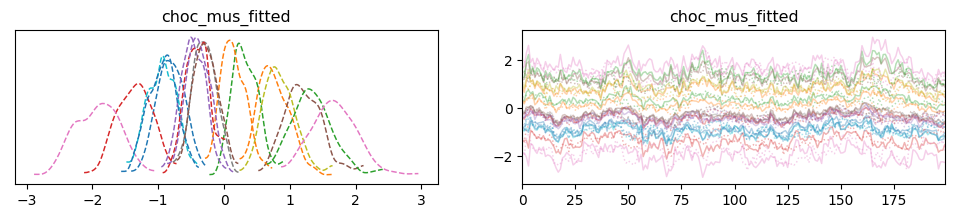

In [4]:
az.plot_trace(idata.posterior, var_names=['choc_mus_fitted'], combined=True)

array([[<AxesSubplot: title={'center': 'choc_mus_std'}>,
        <AxesSubplot: title={'center': 'choc_mus_std'}>]], dtype=object)

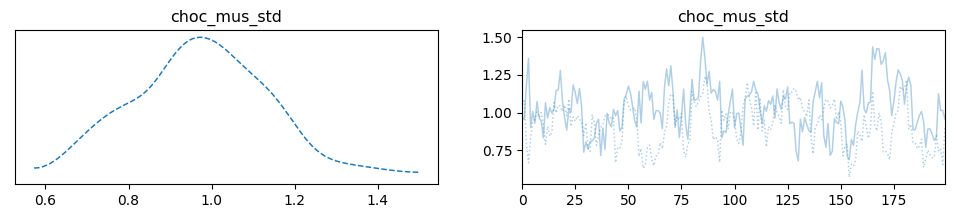

In [5]:
az.plot_trace(idata.posterior, var_names=['choc_mus_std'], combined=True)

array([[<AxesSubplot: title={'center': 'choc_mus_mean'}>,
        <AxesSubplot: title={'center': 'choc_mus_mean'}>]], dtype=object)

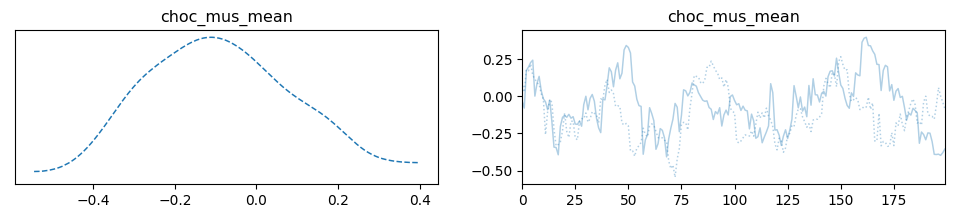

In [6]:
az.plot_trace(idata.posterior, var_names=['choc_mus_mean'], combined=True)

In [7]:
fig = px.violin(idata.posterior.data_vars['choc_mus_fitted'][0,:,:])
for i in range(0, n_chocs):

    fig.add_shape(
        type='line',
        x0=(i-0.5),
        y0=(choc_mus_true[0,i]),
        x1=i+0.5,
        y1=(choc_mus_true[0,i]),
        line=dict(
            color='Red',
        )
    )


fig.update_layout(
{
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
},
showlegend=False)

fig.update_xaxes(showline=True,
                    linewidth=1,
                    linecolor='black',
                    title='chocolate')
fig.update_yaxes(showline=True,
                    linewidth=1,
                    linecolor='black',
                    title='underling preference')

fig.show()